In [43]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
import random
import simpy
from scipy.stats import shapiro
import seaborn as sn
import warnings
warnings.filterwarnings("ignore")

In [2]:
def MMn_queuing(NEW_CUSTOMERS, INTERVAL_CUSTOMERS, SERVER):
    MMn_wait = []

    def source(env, number, interval, counter):
        """Source generates customers randomly"""
        for i in range(number):
            c = customer(env, 'Customer%02d' % i, counter, service_time = 8.0)
            env.process(c)
            t = random.expovariate(1.0/ interval)
            yield env.timeout(t)


    def customer(env, name, counter, service_time):
        """Customer arrives, is served and leaves."""
        arrive = env.now

        with counter.request() as req:
            # Wait for the counter
            yield req

            wait = env.now - arrive
            MMn_wait.append(wait)

            ser_t = random.expovariate(1.0/ service_time)
            yield env.timeout(ser_t)

    # Setup and start the simulation
    env = simpy.Environment()

    # Start processes and run
    counter = simpy.Resource(env, capacity=SERVER)
    env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
    env.run()

    return MMn_wait

In [3]:
def MMn_priority_queuing(NEW_CUSTOMERS, INTERVAL_CUSTOMERS, SERVER):
    MMn_pri_wait = []

    def source(env, number, interval, counter):
        """Source generates customers randomly"""
        for i in range(number):
            c = customer(env, 'Customer%02d' % i, counter, service_time = 8.0)
            env.process(c)
            t = random.expovariate(1.0 / interval)
            yield env.timeout(t)

    def customer(env, name, counter, service_time):
        """Customer arrives, is served and leaves."""
        arrive = env.now
        ser_t = random.expovariate(1.0 / service_time)

        with counter.request(priority=ser_t) as req:
            # Wait for the counter
            yield req

            wait = env.now - arrive
            MMn_pri_wait.append(wait)

            yield env.timeout(ser_t)

    # Setup and start the simulation
    env = simpy.Environment()

    # Start processes and run
    counter = simpy.PriorityResource(env, capacity = SERVER)
    env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
    env.run()

    return MMn_pri_wait

In [4]:
def MDn_queuing(NEW_CUSTOMERS,INTERVAL_CUSTOMERS,SERVER):
    MDn_wait = []

    def source(env, number, interval, counter):
        """Source generates customers randomly"""
        for i in range(number):
            c = customer(env, 'Customer%02d' % i, counter, service_time = 8.0)
            env.process(c)
            t = random.expovariate(1.0 / interval)
            yield env.timeout(t)


    def customer(env, name, counter, service_time):
        """Customer arrives, is served and leaves."""
        arrive = env.now

        with counter.request() as req:
            # Wait for the counter
            yield req

            wait = env.now - arrive
            MDn_wait.append(wait)

            ser_t = service_time
            yield env.timeout(ser_t)

    # Setup and start the simulation
    env = simpy.Environment()

    # Start processes and run
    counter = simpy.Resource(env, capacity=SERVER)
    env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
    env.run()

    return MDn_wait

In [5]:
def MLTn_queuing(NEW_CUSTOMERS,INTERVAL_CUSTOMERS,SERVER):
    MLTn_wait = []

    def source(env, number, interval, counter):
        """Source generates customers randomly"""
        for i in range(number):
            c = customer(env, 'Customer%02d' % i, counter)
            env.process(c)
            t = random.expovariate(1.0/ interval)
            yield env.timeout(t)


    def customer(env, name, counter):
        """Customer arrives, is served and leaves."""
        arrive = env.now

        bernoulli = scipy.stats.bernoulli.rvs(0.75, size=1)
        if bernoulli == 1:
            ser_t = random.expovariate(1.0/ 1)
        else:
            ser_t = random.expovariate(1.0/ 5)

        with counter.request() as req:
            # Wait for the counter
            yield req

            wait = env.now - arrive
            MLTn_wait.append(wait)

            yield env.timeout(ser_t)

    # Setup and start the simulation
    env = simpy.Environment()

    # Start processes and run
    counter = simpy.Resource(env, capacity = SERVER)
    env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
    env.run()

    return MLTn_wait

In [6]:
def MMn(customer, interval, counter, servicetime):
    wait_list = []
    def arrive_customer(env, number, interval, counter):
        for i in range(number):
            c = get_service(env, counter, average_service_time=servicetime)
            env.process(c)
            t = random.expovariate(1/interval)
            yield env.timeout(t)

    def get_service(env, counter, average_service_time):

        arrive_time = env.now

        with counter.request() as req:
            yield req
            wait = env.now - arrive_time
            wait_list.append(wait)

            service_time = random.expovariate( 1/average_service_time)
            yield env.timeout(service_time)

    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=counter)
    env.process(arrive_customer(env,customer,interval,counter))
    env.run()
    #return wait_list[int(0.2*len(wait_list)):int(0.8*len(wait_list))]
    return wait_list

In [31]:
def MMn2(customer, interval, counter, servicetime):
    wait_list = []
    def arrive_customer(env, number, interval, counter):
        for i in range(number):
            c = get_service(env, counter, average_service_time=servicetime)
            env.process(c)
            t = random.expovariate(1/interval)
            yield env.timeout(t)

    def get_service(env, counter, average_service_time):

        arrive_time = env.now

        with counter.request() as req:
            yield req
            wait = env.now - arrive_time
            wait_list.append(wait)

            service_time = random.expovariate( 1/average_service_time)
            yield env.timeout(service_time)
    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=counter)
    env.process(arrive_customer(env,customer,interval,counter))
    env.run()
    return wait_list[int(0.4*len(wait_list)):]
    #return wait_list

#### Comparing mean waiting time about MM1, MM2 and MM4

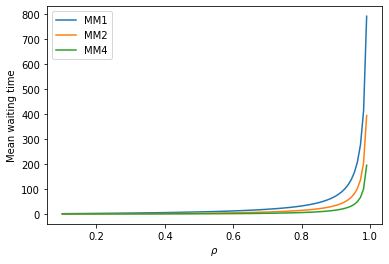

In [59]:
rho_list = np.linspace(0.1, 0.99, 100)
mu = 1 / 8
MM1_list = []
MM2_list = []
MM4_list = []

for i in rho_list:
    MM1 = i / (mu * (1 - i))  # E(W)=rho/(mu*(1-rho))
    MM2 = i ** 2 / (mu * (1 - i ** 2))  # E(W)=rho**2/(mu(1-rho**2))
    MM4 = i ** 4 / (mu * (1 - i ** 4))  # E(W)=rho**4/(mu(1-rho**4))
    MM1_list.append(MM1)
    MM2_list.append(MM2)
    MM4_list.append(MM4)

plt.plot(rho_list, MM1_list, label='MM1')
plt.plot(rho_list, MM2_list, label='MM2')
plt.plot(rho_list, MM4_list, label='MM4')
plt.xlabel("$\\rho$")
plt.ylabel("Mean waiting time")
plt.legend(loc="best")
# plt.savefig("mean wait time vs rho", dpi=400)
plt.show()

#### Different number of customers with fixed rho

rho -- 0.8
AverageWaitingTime: 4.586674062305829
AverageWaitingTime: 5.728408892930715
AverageWaitingTime: 5.779425201721438
AverageWaitingTime: 5.900012201632714


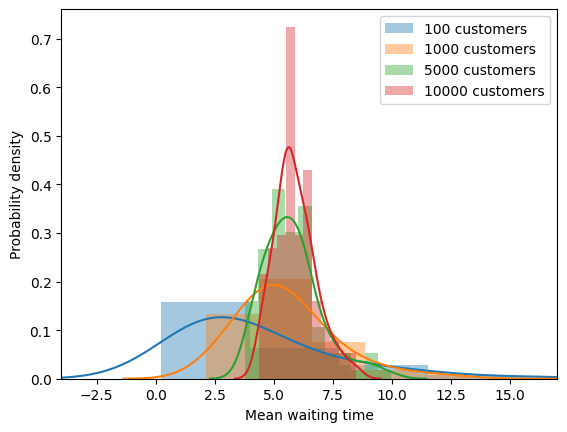

In [16]:
# MM4 rho = 0.8
simulation = 100
customers = [100,1000,5000,10000]
interval_ave = 2.5
server_num = 4
service_ave = 8

rho = service_ave / (server_num * interval_ave)
print('rho --', rho)

for cust in customers:
    waiting = []
    for sim in range(simulation):
        waiting.append(np.mean(MMn(customer = cust,
                                   interval = interval_ave,
                                   counter = server_num,
                                   servicetime = service_ave)))

    sn.distplot(waiting, bins = 11, label = '%s customers'%(cust))
    print('AverageWaitingTime:', np.mean(waiting))

plt.xlabel('Mean waiting time')
plt.ylabel('Probability density')
plt.legend()
plt.xlim(-4, 17)
plt.savefig('plots/MM/customers_MM4',dpi = 400)
plt.show()

rho --  0.4
AverageWaitingTime: 0.2556763920124099
AverageWaitingTime: 0.29019778457019124
AverageWaitingTime: 0.29362841288926567
AverageWaitingTime: 0.3080801120385881


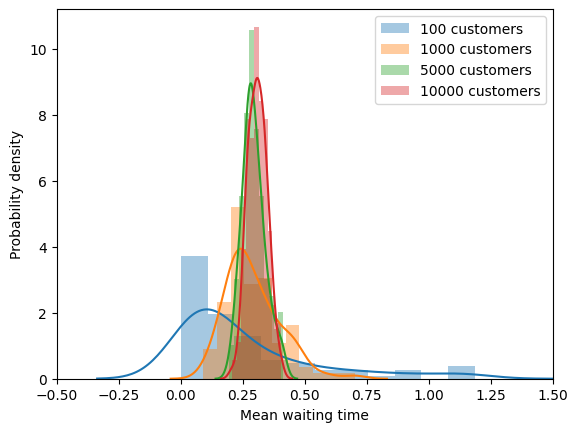

In [18]:
# MM4 rho = 0.4
simulation = 100
customer_number = [100, 1000, 5000, 10000]
interval_ave = 5
server_num = 4
service_ave = 8

rho = service_ave / (server_num * interval_ave)
print('rho -- ', rho)

for cust in customer_number:
    waiting = []
    for sim in range(simulation):
        waiting.append(np.mean(MMn(customer = cust,
                                   interval = interval_ave,
                                   counter = server_num,
                                   servicetime = service_ave)))
    sn.distplot(waiting,bins=11,label = '%s customers'%(cust))
    print('AverageWaitingTime:', np.mean(waiting))

plt.xlabel('Mean waiting time')
plt.ylabel('Probability density')
plt.legend()
plt.xlim(-0.5,1.5)
plt.savefig('plots/MM/customers_MM4-4-rho', dpi = 400)
plt.show()

#### Comparison with and without ignoring the first 20% data

In [36]:
simulation = 100
customer_number = 10000
# customer_number = 1000
interval_ave = 2.5
server_num = 4
service_ave = 8   #rho=0.8
waiting = []
waitingcut = []

for simu in range(simulation):
    waiting.append(np.mean(MMn(customer = customer_number,
                               interval = interval_ave,
                               counter = server_num,
                               servicetime = service_ave)))
    # in MMn2(), the first 20% data is ignored, remove the warming up period
    waitingcut.append(np.mean(MMn2(customer = customer_number,
                               interval = interval_ave,
                               counter = server_num,
                               servicetime = service_ave)))

Exclude 20%  6.009204560999624 pvalue ShapiroResult(statistic=0.9531581997871399, pvalue=0.0013474170118570328)
Full 5.856389380371331 pvalue ShapiroResult(statistic=0.9884725213050842, pvalue=0.5436723232269287)


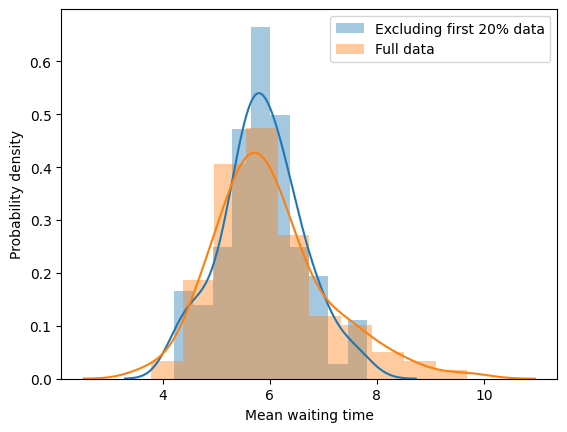

In [37]:
sn.distplot(waiting, bins=10, label = 'Excluding first 20% data')
sn.distplot(waitingcut, bins = 10, label = 'Full data')
print('Exclude 20% ', np.mean(waitingcut), 'pvalue', shapiro(waitingcut))
print('Full', np.mean(waiting), 'pvalue', shapiro(waiting))
plt.xlabel('Mean waiting time')
plt.ylabel('Probability density')
plt.legend()
plt.savefig('plots/exclude-first-20-data-10000', dpi = 400)
plt.show()

#### check MM4 priority steady state

rho --  0.8
AverageWaitingTime: 2.153345317325962
AverageWaitingTime: 3.034900056434785
AverageWaitingTime: 3.1239182877704503
AverageWaitingTime: 3.1265907495438565


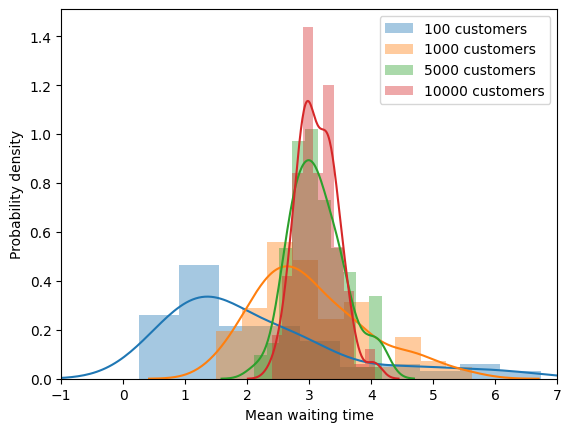

In [40]:
simulation = 100
customer_number = [100, 1000, 5000, 10000]
interval_ave = 2.5
server_num = 4
service_ave = 8

rho = service_ave / (server_num * interval_ave)
print('rho -- ', rho)

for number in customer_number:
    waiting = []
    for simu in range(simulation):
        waiting.append(np.mean(MMn_priority_queuing(number, interval_ave, server_num)))
    sn.distplot(waiting, bins = 10, label = '%s customers'%(number))
    print('AverageWaitingTime:',np.mean(waiting))

plt.xlabel('Mean waiting time')
plt.ylabel('Probability density')
plt.legend()
plt.xlim(-1,7)
plt.savefig('plots/MM/customers_MM4-priority', dpi=400)
plt.show()

#### check M/D/4 steady state

rho --  0.8
AverageWaitingTime: 2.634688447955718
AverageWaitingTime: 3.029676021574842
AverageWaitingTime: 3.0523684225312797
AverageWaitingTime: 3.0746436710583733


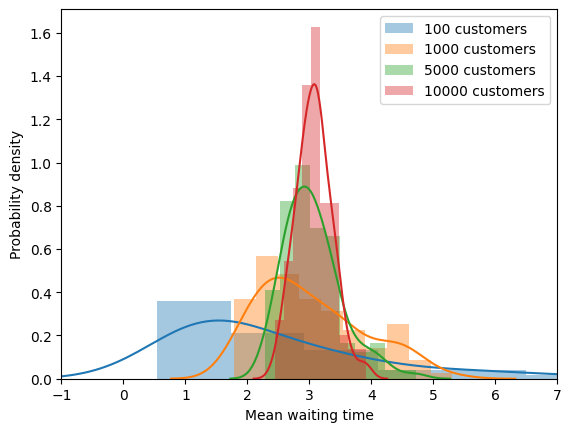

In [41]:
simulation = 100
customer_number = [100, 1000, 5000,  10000]
interval_ave = 2.5
server_num = 4
service_ave = 8

rho = service_ave / (server_num * interval_ave)
print('rho -- ', rho)

for cust in customers:
    waiting = []
    for simu in range(simulation):
        waiting.append(np.mean(MDn_queuing(cust,interval_ave,server_num)))
    sn.distplot(waiting,bins=10,label='%s customers'%(cust))
    print('AverageWaitingTime:',np.mean(waiting))

plt.xlabel('Mean waiting time')
plt.ylabel('Probability density')
plt.legend()
plt.xlim(-1,7)
plt.savefig('plots/MD/customers_MD4', dpi=400)
plt.show()

#### check M/LT/4 steady state

rho --  0.8
AverageWaitingTime: 1.1442688912298942
AverageWaitingTime: 2.4182999810340053
AverageWaitingTime: 2.5968459412987137
AverageWaitingTime: 2.409175793238947


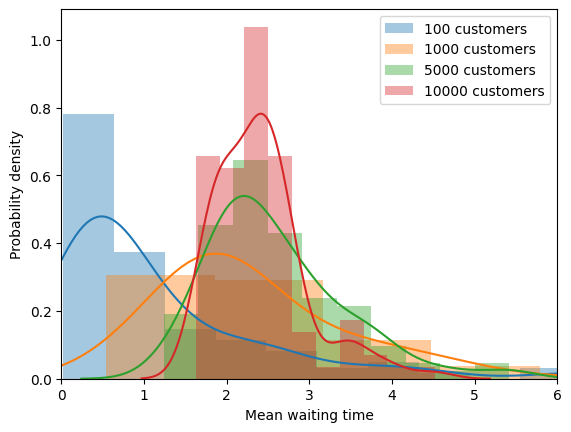

In [42]:
simulation = 100
customer_number = [100, 1000, 5000, 10000]
interval_ave = 2.5/4
server_num = 4
service_ave = 2

rho = service_ave / (server_num * interval_ave)
print('rho -- ', rho)

for number in customer_number:
    waiting = []
    for simu in range(simulation):
        waiting.append(np.mean(MLTn_queuing(number,interval_ave,server_num)))
    sn.distplot(waiting, bins = 10, label = '%s customers'%(number))
    print('AverageWaitingTime:',np.mean(waiting))

plt.xlabel('Mean waiting time')
plt.ylabel('Probability density')
plt.legend()
plt.xlim(0,6)
plt.savefig('plots/MLt/customers_MLt4', dpi=400)
plt.show()